# Duration Prediction Model

## Analysis

In [2]:
!python -V

Python 3.9.19


### Import Packages

In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/tsimpson_unix/ml_ops_zoomcamp/w2_experiment_tracking/mlruns/1', creation_time=1716205390239, experiment_id='1', last_update_time=1716205390239, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

### Read Data

In [5]:
df = pd.read_csv('../data/green_tripdata_2021-01.csv')

/tmp/ipykernel_696286/1973399759.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/green_tripdata_2021-01.csv')


### Review Data

In [6]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.5,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.5,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.5,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.5,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.0,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,0.0,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,0.0,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,0.0,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,0.0,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN


In [7]:
df.dtypes

VendorID                 float64
lpep_pickup_datetime      object
lpep_dropoff_datetime     object
store_and_fwd_flag        object
RatecodeID               float64
PULocationID               int64
DOLocationID               int64
passenger_count          float64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
ehail_fee                float64
improvement_surcharge    float64
total_amount             float64
payment_type             float64
trip_type                float64
congestion_surcharge     float64
dtype: object

### EDA and feature generation

In [8]:
# Convert datetime columns to datetime dtype
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [9]:
df.dtypes

VendorID                        float64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [10]:
# Set filter so we only have trip_type code 2 which corresponds to dispatch
# We do not want street-hail data
# df = df[df.trip_type == 2]
# We are commenting this out because it was causing weird data distributions 

In [11]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.5,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.5,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.5,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.5,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.0,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,0.0,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,0.0,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,0.0,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,0.0,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN


In [12]:
# Calculate duration
df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime)

In [13]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,...,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN,0 days 00:16:00
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,...,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN,0 days 00:09:00
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,...,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN,0 days 00:04:00
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,...,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN,0 days 00:42:00


In [14]:
# Duration is not very useful in this form, conver to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [15]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00,3.933333
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75,8.750000
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00,5.966667
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00,7.083333
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,...,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN,16.000000
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,...,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN,9.000000
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,...,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN,4.000000
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,...,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN,42.000000


In [16]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [17]:
# There were many odd low durations so let's take a look at the percentiles
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [18]:
((df.duration >= 1) & (df. duration <= 50)).mean()

0.9508873729057216

In [19]:
# Only 50% of trip durations are between 1 and 50 minutes which seems strange
# Because of this we commented out the filtering of only type 2 rides which made this number look much more accurate

In [20]:
df = df[(df.duration >= 1) & (df. duration <= 60)]

In [21]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00,3.933333
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75,8.750000
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00,5.966667
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00,7.083333
7,2.0,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,NaN,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,...,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN,16.000000
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,...,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN,9.000000
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,...,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN,4.000000
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,...,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN,42.000000


In [22]:
# Let's take a look at categorical variables and split out the numericals

In [23]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [24]:
# Check dtype of categoricals
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [25]:
# We can convert these via encoding so they can be used in a model
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_696286/2496045046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [27]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

### Model creation

In [28]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [29]:
# This vectorizer will transform the categorical features into a vector so categoricals can be used in the model
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [30]:
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [31]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [32]:
target = 'duration'
y_train = df[target].values

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_696286/3831492026.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_696286/3831492026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


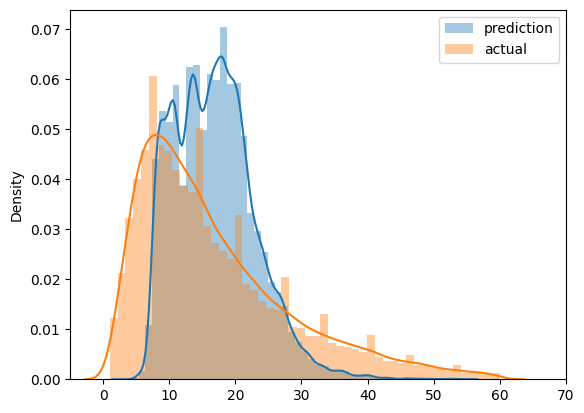

In [35]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.xlim(-5, 70)

plt.legend()

plt.show()

In [36]:
mean_squared_error(y_train, y_pred, squared=False)

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829497

In [37]:
# On average our model is wrong by about 10 minutes which isn't good but it's a start

### Model improvement

In [38]:
# First lets combine all of our cleaning and feature generation into a pre-processing function we can execute

def read_dataframe(filename):
    df = pd.read_csv(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime)
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df. duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    #numerical = ['trip_distance'] #numerical not needed in this function since we don't do preprocessing on it

    df[categorical] = df[categorical].astype(str)
    
    return df

In [39]:
# Now we can easily create train and validation sets since pre-processing has been condensed into a function
df_train = read_dataframe('../data/green_tripdata_2021-01.csv')
df_val = read_dataframe('../data/green_tripdata_2021-02.csv')

/tmp/ipykernel_696286/3151220129.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [40]:
len(df_train), len(df_val)

(73908, 61921)

In [41]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [42]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2.0,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,NaN,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2.0,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,NaN,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2.0,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,NaN,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2.0,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,NaN,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2.0,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,NaN,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,NaN,2021-02-26 08:46:00,2021-02-26 08:59:00,NaN,NaN,167,247,NaN,1.47,14.55,...,0.00,0.0,NaN,0.3,17.60,NaN,NaN,NaN,13.000000,167_247
64568,NaN,2021-02-26 08:56:00,2021-02-26 09:10:00,NaN,NaN,89,123,NaN,2.87,20.22,...,0.00,0.0,NaN,0.3,23.27,NaN,NaN,NaN,14.000000,89_123
64569,NaN,2021-02-26 08:46:00,2021-02-26 09:07:00,NaN,NaN,127,166,NaN,4.74,24.94,...,0.00,0.0,NaN,0.3,30.74,NaN,NaN,NaN,21.000000,127_166
64570,NaN,2021-02-26 08:17:00,2021-02-26 08:51:00,NaN,NaN,42,137,NaN,7.63,41.81,...,0.00,0.0,NaN,0.3,44.86,NaN,NaN,NaN,34.000000,42_137


In [43]:
# Now let's combine all the post-processing and include the steps for our validation set

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts) # Note we just transform not fit_transform here we don't want learning to take place

In [44]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.7587152053176585

In [46]:
# Now that we have a baseline let's try other models such as Lasso
# Lasso introduces some regularization

lr = Lasso()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


12.212583224318816

In [47]:
"""# Worse with default but we can change parameters

lr = Lasso(alpha = 0.005) # Note I tested multiple alpha values
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)"""

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


10.696342127127648

In [49]:
# Let's try another model Ridge regression another form of regulrizated linear regression
with mlflow.start_run():

    # mlflow.set_tag("tag1", "tag2") # You can use this to add developer name and other useful tags
    # Here is an example of parameter logging where we do basic data "versioning"
    mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.csv")
    mlflow.log_param("val-data-path", "../data/green_tripdata_2021-02.csv")

    alpha = 0.01
    mlflow.log_param("alpha", alpha) # Keep track of each alpha we pass

    lr = Ridge(alpha) # Note I tested multiple alpha values
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [86]:
# We are going to add to and manipulate features above which won't be evident scrolling through the notebook so I will note it here
# 1. Adding PU_DO feature to combine pickup and dropoff locations and removed them individually
# This improved the model accuracy from ~10% to ~7%

In [53]:
# Experiment tracking demo

import xgboost as xgb

"""
fmin - finds minimum of output
tpe - algorithm to control logic
hp - library that contains methods to define ranges for each hyperparameter
STATUS_OK - at end of each run tells the system it is ok
Trials - keeps track of information from each run
scope - determines range of type int
"""
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# First we must set the train and validation data to the correct format for xgboost
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params, # Specify parameters which are input variables in this case
            dtrain=train, # Specify training dataset
            num_boost_round=1000, # Set maximum iterations
            evals=[(valid, "validation")], # Specify evaluation dataset
            early_stopping_rounds=50 # If 50 iterations go without improvement early stop is done
        )

        y_pred=booster.predict(valid) # Once model trained, make predictions on validation set
        rmse=mean_squared_error(y_val, y_pred, squared=False) # RMSE to determine performance
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
    
search_space = {
    # Controls depth of trees (converts float to int inside)
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1)),
    # Learning rate from exp(-3), exp(0) basically [0.05 to 1]
    'learning_rate': hp.loguniform('learning_rate',-3,0),
    # Using similar loguniform logic as above for alpha and weight
    'reg_alpha': hp.loguniform('reg_alpha',-5,-1),
    'reg_lambda': hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective': 'reg:linear',
    'seed':42,
}

best_result = fmin(
    # Pass all of the above to the fmin function which will minimize output to find best method
    fn=objective, # Define the function we created above
    space=search_space, # Pass search space
    algo=tpe.suggest, # Optimization algorithm we are running
    max_evals=50,
    trials=Trials() # Where information of each run is stored
)   

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:24:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20388                          
[1]	validation-rmse:10.35890                          
[2]	validation-rmse:9.65480                           
[3]	validation-rmse:9.07137                           
[4]	validation-rmse:8.59096                           
[5]	validation-rmse:8.20016                           
[6]	validation-rmse:7.88156                           
[7]	validation-rmse:7.62203                           
[8]	validation-rmse:7.41307                           
[9]	validation-rmse:7.24175                           
[10]	validation-rmse:7.10521                          
[11]	validation-rmse:6.99385                          
[12]	validation-rmse:6.90376                          
[13]	validation-rmse:6.82917                          
[14]	validation-rmse:6.76996                          
[15]	validation-rmse:6.72173                          
[16]	validation-rmse:6.68053                          
[17]	validation-rmse:6.64758                          
[18]	valid

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:24:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.52996                                                    
[1]	validation-rmse:7.28447                                                    
[2]	validation-rmse:6.89205                                                    
[3]	validation-rmse:6.75760                                                    
[4]	validation-rmse:6.69941                                                    
[5]	validation-rmse:6.66913                                                    
[6]	validation-rmse:6.65199                                                    
[7]	validation-rmse:6.64017                                                    
[8]	validation-rmse:6.63508                                                    
[9]	validation-rmse:6.63062                                                    
[10]	validation-rmse:6.62727                                                   
[11]	validation-rmse:6.62518                                                   
[12]	validation-rmse:6.62276            

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:25:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:7.92232
[7]	validation-rmse:7.68679                                                    
[8]	validation-rmse:7.49939                                                    
[9]	validation-rmse:7.35066                                                    
[10]	validation-rmse:7.23250                                                   
[11]	validation-rmse:7.13840                                                   
[12]	validation-rmse:7.06342                                                   
[13]	validation-rmse:7.00400                                                   
[14]	validation-rmse:6.95574                                                   
[15]	validation-rmse:6.91669                                                   
[16]	validation-rmse:6.88499                                                   
[17]	validation-rmse:6.85986                                                   
[18]	validation-rmse:6.83923                                                   
[19]	validat

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:25:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.20627                                                    
[2]	validation-rmse:6.87215                                                    
[3]	validation-rmse:6.76299                                                    
[4]	validation-rmse:6.71489                                                    
[5]	validation-rmse:6.69379                                                    
[6]	validation-rmse:6.67514                                                    
[7]	validation-rmse:6.66477                                                    
[8]	validation-rmse:6.66016                                                    
[9]	validation-rmse:6.65780                                                    
[10]	validation-rmse:6.65669                                                   
[11]	validation-rmse:6.65541                                                   
[12]	validation-rmse:6.65442                                                   
[13]	validation-rmse:6.65295            

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:25:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.86590                                                   
[1]	validation-rmse:9.81256                                                    
[2]	validation-rmse:8.99764                                                    
[3]	validation-rmse:8.37552                                                    
[4]	validation-rmse:7.90544                                                    
[5]	validation-rmse:7.55210                                                    
[6]	validation-rmse:7.28876                                                    
[7]	validation-rmse:7.09222                                                    
[8]	validation-rmse:6.94432                                                    
[9]	validation-rmse:6.83500                                                    
[10]	validation-rmse:6.75300                                                   
[11]	validation-rmse:6.68831                                                   
[12]	validation-rmse:6.64090            

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:26:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.33418                                                   
[1]	validation-rmse:10.58167                                                   
[2]	validation-rmse:9.94213                                                    
[3]	validation-rmse:9.39897                                                    
[4]	validation-rmse:8.94114                                                    
[5]	validation-rmse:8.55307                                                    
[6]	validation-rmse:8.23306                                                    
[7]	validation-rmse:7.96301                                                    
[8]	validation-rmse:7.73623                                                    
[9]	validation-rmse:7.55120                                                    
[10]	validation-rmse:7.39896                                                   
[11]	validation-rmse:7.27022                                                   
[12]	validation-rmse:7.16257            

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:27:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.47803                                                    
[1]	validation-rmse:7.15581                                                    
[2]	validation-rmse:6.71939                                                    
[3]	validation-rmse:6.56764                                                    
[4]	validation-rmse:6.50164                                                    
[5]	validation-rmse:6.46775                                                    
[6]	validation-rmse:6.45013                                                    
[7]	validation-rmse:6.44027                                                    
[8]	validation-rmse:6.43285                                                    
[9]	validation-rmse:6.42983                                                    
[10]	validation-rmse:6.42445                                                   
[11]	validation-rmse:6.41920                                                   
[12]	validation-rmse:6.41431            

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:27:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.04843                                                   
[1]	validation-rmse:8.68129                                                    
[2]	validation-rmse:7.83468                                                    
[3]	validation-rmse:7.32742                                                    
[4]	validation-rmse:7.04261                                                    
[5]	validation-rmse:6.85699                                                    
[6]	validation-rmse:6.75000                                                    
[7]	validation-rmse:6.67624                                                    
[8]	validation-rmse:6.63371                                                    
[9]	validation-rmse:6.60494                                                    
[10]	validation-rmse:6.58330                                                   
[11]	validation-rmse:6.56809                                                   
[12]	validation-rmse:6.55755            

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:27:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[9]	validation-rmse:7.05888                                                    
[10]	validation-rmse:6.99044                                                   
[11]	validation-rmse:6.94070                                                   
[12]	validation-rmse:6.90533                                                   
[13]	validation-rmse:6.87841                                                   
[14]	validation-rmse:6.85715                                                   
[15]	validation-rmse:6.83999                                                   
[16]	validation-rmse:6.82826                                                   
[17]	validation-rmse:6.81669                                                   
[18]	validation-rmse:6.80594                                                   
[19]	validation-rmse:6.79991                                                   
[20]	validation-rmse:6.79138                                                   
[21]	validation-rmse:6.78651            

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:28:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.67344                                                    
[2]	validation-rmse:6.65990                                                    
[3]	validation-rmse:6.64772                                                    
[4]	validation-rmse:6.63147                                                    
[5]	validation-rmse:6.62212                                                    
[6]	validation-rmse:6.61623                                                    
[7]	validation-rmse:6.60956                                                    
[8]	validation-rmse:6.60591                                                    
[9]	validation-rmse:6.59750                                                    
[10]	validation-rmse:6.59393                                                   
[11]	validation-rmse:6.58783                                                   
[12]	validation-rmse:6.57846                                                   
[13]	validation-rmse:6.57423            

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:28:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.86827                                                    
[1]	validation-rmse:9.82200                                                     
[2]	validation-rmse:9.01711                                                     
[3]	validation-rmse:8.40582                                                     
[4]	validation-rmse:7.94611                                                     
[5]	validation-rmse:7.60419                                                     
[6]	validation-rmse:7.35047                                                     
[7]	validation-rmse:7.16126                                                     
[8]	validation-rmse:7.01969                                                     
[9]	validation-rmse:6.91468                                                     
[10]	validation-rmse:6.83698                                                    
[11]	validation-rmse:6.77395                                                    
[12]	validation-rmse:6.72755

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:28:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.83086                                                     
[1]	validation-rmse:6.90377                                                     
[2]	validation-rmse:6.69852                                                     
[3]	validation-rmse:6.62969                                                     
[4]	validation-rmse:6.60638                                                     
[5]	validation-rmse:6.59137                                                     
[6]	validation-rmse:6.58554                                                     
[7]	validation-rmse:6.58132                                                     
[8]	validation-rmse:6.57730                                                     
[9]	validation-rmse:6.57419                                                     
[10]	validation-rmse:6.56086                                                    
[11]	validation-rmse:6.56024                                                    
[12]	validation-rmse:6.55716

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:28:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.04056                                                    
[1]	validation-rmse:10.09798                                                    
[2]	validation-rmse:9.33540                                                     
[3]	validation-rmse:8.73544                                                     
[4]	validation-rmse:8.25853                                                     
[5]	validation-rmse:7.89076                                                     
[6]	validation-rmse:7.59601                                                     
[7]	validation-rmse:7.37030                                                     
[8]	validation-rmse:7.19567                                                     
[9]	validation-rmse:7.05909                                                     
[10]	validation-rmse:6.95855                                                    
[11]	validation-rmse:6.87631                                                    
[12]	validation-rmse:6.81259

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:29:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64808                                                    
[1]	validation-rmse:11.13484                                                    
[2]	validation-rmse:10.66929                                                    
[3]	validation-rmse:10.24869                                                    
[4]	validation-rmse:9.86663                                                     
[5]	validation-rmse:9.52294                                                     
[6]	validation-rmse:9.21335                                                     
[7]	validation-rmse:8.93634                                                     
[8]	validation-rmse:8.68621                                                     
[9]	validation-rmse:8.46205                                                     
[10]	validation-rmse:8.26374                                                    
[11]	validation-rmse:8.08487                                                    
[12]	validation-rmse:7.92552

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:30:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.83341                                                     
[2]	validation-rmse:7.98833                                                     
[3]	validation-rmse:7.46764                                                     
[4]	validation-rmse:7.14846                                                     
[5]	validation-rmse:6.95427                                                     
[6]	validation-rmse:6.83158                                                     
[7]	validation-rmse:6.75484                                                     
[8]	validation-rmse:6.70149                                                     
[9]	validation-rmse:6.66646                                                     
[10]	validation-rmse:6.64214                                                    
[11]	validation-rmse:6.62539                                                    
[12]	validation-rmse:6.61312                                                    
[13]	validation-rmse:6.60172

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:30:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.70444                                                    
[1]	validation-rmse:9.57329                                                     
[2]	validation-rmse:8.73876                                                     
[3]	validation-rmse:8.13172                                                     
[4]	validation-rmse:7.69407                                                     
[5]	validation-rmse:7.38516                                                     
[6]	validation-rmse:7.16430                                                     
[7]	validation-rmse:7.00702                                                     
[8]	validation-rmse:6.89412                                                     
[9]	validation-rmse:6.81460                                                     
[10]	validation-rmse:6.75534                                                    
[11]	validation-rmse:6.71157                                                    
[12]	validation-rmse:6.67831

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:31:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.74092                                                     
[1]	validation-rmse:8.29312                                                     
[2]	validation-rmse:7.47960                                                     
[3]	validation-rmse:7.03629                                                     
[4]	validation-rmse:6.79539                                                     
[5]	validation-rmse:6.66290                                                     
[6]	validation-rmse:6.58444                                                     
[7]	validation-rmse:6.53531                                                     
[8]	validation-rmse:6.50179                                                     
[9]	validation-rmse:6.47941                                                     
[10]	validation-rmse:6.46281                                                    
[11]	validation-rmse:6.44875                                                    
[12]	validation-rmse:6.44218

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:31:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.32826                                                    
[1]	validation-rmse:9.02778                                                     
[2]	validation-rmse:8.15614                                                     
[3]	validation-rmse:7.57994                                                     
[4]	validation-rmse:7.20955                                                     
[5]	validation-rmse:6.97042                                                     
[6]	validation-rmse:6.81420                                                     
[7]	validation-rmse:6.70764                                                     
[8]	validation-rmse:6.63665                                                     
[9]	validation-rmse:6.58794                                                     
[10]	validation-rmse:6.55275                                                    
[11]	validation-rmse:6.52852                                                    
[12]	validation-rmse:6.50908

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:32:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.37565                                                     
[1]	validation-rmse:7.90999                                                     
[2]	validation-rmse:7.19647                                                     
[3]	validation-rmse:6.85394                                                     
[4]	validation-rmse:6.68355                                                     
[5]	validation-rmse:6.59532                                                     
[6]	validation-rmse:6.54318                                                     
[7]	validation-rmse:6.51321                                                     
[8]	validation-rmse:6.49451                                                     
[9]	validation-rmse:6.48291                                                     
[10]	validation-rmse:6.47775                                                    
[11]	validation-rmse:6.47087                                                    
[12]	validation-rmse:6.46693

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:32:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.65098                                                    
[1]	validation-rmse:9.48597                                                     
[2]	validation-rmse:8.62929                                                     
[3]	validation-rmse:8.01069                                                     
[4]	validation-rmse:7.56638                                                     
[5]	validation-rmse:7.25652                                                     
[6]	validation-rmse:7.03539                                                     
[7]	validation-rmse:6.87887                                                     
[8]	validation-rmse:6.76565                                                     
[9]	validation-rmse:6.68631                                                     
[10]	validation-rmse:6.62576                                                    
[11]	validation-rmse:6.58169                                                    
[12]	validation-rmse:6.54818

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:32:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64560                                                    
[1]	validation-rmse:11.12888                                                    
[2]	validation-rmse:10.66001                                                    
[3]	validation-rmse:10.23432                                                    
[4]	validation-rmse:9.84990                                                     
[5]	validation-rmse:9.50232                                                     
[6]	validation-rmse:9.18714                                                     
[7]	validation-rmse:8.90491                                                     
[8]	validation-rmse:8.65066                                                     
[9]	validation-rmse:8.42272                                                     
[10]	validation-rmse:8.21889                                                    
[11]	validation-rmse:8.03634                                                    
[12]	validation-rmse:7.87353

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:33:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75424                                                    
[1]	validation-rmse:11.32947                                                    
[2]	validation-rmse:10.93635                                                    
[3]	validation-rmse:10.57297                                                    
[4]	validation-rmse:10.23752                                                    
[5]	validation-rmse:9.92757                                                     
[6]	validation-rmse:9.64382                                                     
[7]	validation-rmse:9.38405                                                     
[8]	validation-rmse:9.14464                                                     
[9]	validation-rmse:8.92398                                                     
[10]	validation-rmse:8.72279                                                    
[11]	validation-rmse:8.53845                                                    
[12]	validation-rmse:8.36872

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:34:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42598                                                    
[1]	validation-rmse:10.73624                                                    
[2]	validation-rmse:10.13608                                                    
[3]	validation-rmse:9.61480                                                     
[4]	validation-rmse:9.16494                                                     
[5]	validation-rmse:8.77469                                                     
[6]	validation-rmse:8.43938                                                     
[7]	validation-rmse:8.15253                                                     
[8]	validation-rmse:7.90856                                                     
[9]	validation-rmse:7.69906                                                     
[10]	validation-rmse:7.52192                                                    
[11]	validation-rmse:7.37099                                                    
[12]	validation-rmse:7.24301

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:35:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.43418                                                    
[1]	validation-rmse:10.75092                                                    
[2]	validation-rmse:10.15518                                                    
[3]	validation-rmse:9.63778                                                     
[4]	validation-rmse:9.18899                                                     
[5]	validation-rmse:8.80057                                                     
[6]	validation-rmse:8.46494                                                     
[7]	validation-rmse:8.17769                                                     
[8]	validation-rmse:7.93208                                                     
[9]	validation-rmse:7.72328                                                     
[10]	validation-rmse:7.54326                                                    
[11]	validation-rmse:7.39311                                                    
[12]	validation-rmse:7.26053

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:36:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.49260                                                    
[1]	validation-rmse:10.85794                                                    
[2]	validation-rmse:10.29886                                                    
[3]	validation-rmse:9.80556                                                     
[4]	validation-rmse:9.37751                                                     
[5]	validation-rmse:9.00450                                                     
[6]	validation-rmse:8.68154                                                     
[7]	validation-rmse:8.39132                                                     
[8]	validation-rmse:8.14586                                                     
[9]	validation-rmse:7.93206                                                     
[10]	validation-rmse:7.74828                                                    
[11]	validation-rmse:7.59099                                                    
[12]	validation-rmse:7.45413

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:37:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75736                                                    
[1]	validation-rmse:11.33455                                                    
[2]	validation-rmse:10.94272                                                    
[3]	validation-rmse:10.58012                                                    
[4]	validation-rmse:10.24464                                                    
[5]	validation-rmse:9.93500                                                     
[6]	validation-rmse:9.64920                                                     
[7]	validation-rmse:9.38556                                                     
[8]	validation-rmse:9.14356                                                     
[9]	validation-rmse:8.92083                                                     
[10]	validation-rmse:8.71663                                                    
[11]	validation-rmse:8.52916                                                    
[12]	validation-rmse:8.35782

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:38:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.23043                                                    
[1]	validation-rmse:10.40331                                                    
[2]	validation-rmse:9.71095                                                     
[3]	validation-rmse:9.13507                                                     
[4]	validation-rmse:8.65894                                                     
[5]	validation-rmse:8.26789                                                     
[6]	validation-rmse:7.94632                                                     
[7]	validation-rmse:7.68455                                                     
[8]	validation-rmse:7.47156                                                     
[9]	validation-rmse:7.29820                                                     
[10]	validation-rmse:7.15875                                                    
[11]	validation-rmse:7.04490                                                    
[12]	validation-rmse:6.95272

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:39:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.55247                                                    
[1]	validation-rmse:10.96324                                                    
[2]	validation-rmse:10.43791                                                    
[3]	validation-rmse:9.97112                                                     
[4]	validation-rmse:9.55860                                                     
[5]	validation-rmse:9.19472                                                     
[6]	validation-rmse:8.86964                                                     
[7]	validation-rmse:8.58505                                                     
[8]	validation-rmse:8.33749                                                     
[9]	validation-rmse:8.12190                                                     
[10]	validation-rmse:7.92621                                                    
[11]	validation-rmse:7.75971                                                    
[12]	validation-rmse:7.61512

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:40:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64141                                                    
[1]	validation-rmse:11.12419                                                    
[2]	validation-rmse:10.65297                                                    
[3]	validation-rmse:10.22743                                                    
[4]	validation-rmse:9.84380                                                     
[5]	validation-rmse:9.50014                                                     
[6]	validation-rmse:9.19013                                                     
[7]	validation-rmse:8.91282                                                     
[8]	validation-rmse:8.66130                                                     
[9]	validation-rmse:8.43879                                                     
[10]	validation-rmse:8.23920                                                    
[11]	validation-rmse:8.06286                                                    
[12]	validation-rmse:7.90500

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:41:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79517                                                    
[1]	validation-rmse:11.40463                                                    
[2]	validation-rmse:11.04051                                                    
[3]	validation-rmse:10.70105                                                    
[4]	validation-rmse:10.38494                                                    
[5]	validation-rmse:10.09039                                                    
[6]	validation-rmse:9.81750                                                     
[7]	validation-rmse:9.56250                                                     
[8]	validation-rmse:9.32725                                                     
[9]	validation-rmse:9.10868                                                     
[10]	validation-rmse:8.90592                                                    
[11]	validation-rmse:8.71906                                                    
[12]	validation-rmse:8.54683

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:42:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35463                                                    
[1]	validation-rmse:10.61727                                                    
[2]	validation-rmse:9.98605                                                     
[3]	validation-rmse:9.44463                                                     
[4]	validation-rmse:8.99322                                                     
[5]	validation-rmse:8.59703                                                     
[6]	validation-rmse:8.27001                                                     
[7]	validation-rmse:7.99316                                                     
[8]	validation-rmse:7.76347                                                     
[9]	validation-rmse:7.57536                                                     
[10]	validation-rmse:7.41184                                                    
[11]	validation-rmse:7.27852                                                    
[12]	validation-rmse:7.16874

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:43:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.16477                                                    
[1]	validation-rmse:10.29521                                                    
[2]	validation-rmse:9.57982                                                     
[3]	validation-rmse:8.99363                                                     
[4]	validation-rmse:8.51797                                                     
[5]	validation-rmse:8.13296                                                     
[6]	validation-rmse:7.82354                                                     
[7]	validation-rmse:7.57610                                                     
[8]	validation-rmse:7.37935                                                     
[9]	validation-rmse:7.22173                                                     
[10]	validation-rmse:7.09429                                                    
[11]	validation-rmse:6.99470                                                    
[12]	validation-rmse:6.91420

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:43:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.11725                                                    
[1]	validation-rmse:10.21973                                                    
[2]	validation-rmse:9.49083                                                     
[3]	validation-rmse:8.90285                                                     
[4]	validation-rmse:8.43200                                                     
[5]	validation-rmse:8.05836                                                     
[6]	validation-rmse:7.76285                                                     
[7]	validation-rmse:7.52963                                                     
[8]	validation-rmse:7.34597                                                     
[9]	validation-rmse:7.20187                                                     
[10]	validation-rmse:7.08932                                                    
[11]	validation-rmse:7.00100                                                    
[12]	validation-rmse:6.92685

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:44:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.46341                                                     
[3]	validation-rmse:7.89285                                                     
[4]	validation-rmse:7.50072                                                     
[5]	validation-rmse:7.23832                                                     
[6]	validation-rmse:7.06353                                                     
[7]	validation-rmse:6.94593                                                     
[8]	validation-rmse:6.86372                                                     
[9]	validation-rmse:6.80652                                                     
[10]	validation-rmse:6.76602                                                    
[11]	validation-rmse:6.73485                                                    
[12]	validation-rmse:6.71427                                                    
[13]	validation-rmse:6.69875                                                    
[14]	validation-rmse:6.68579

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:45:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57657                                                    
[1]	validation-rmse:11.00683                                                    
[2]	validation-rmse:10.49830                                                    
[3]	validation-rmse:10.04185                                                    
[4]	validation-rmse:9.63603                                                     
[5]	validation-rmse:9.27434                                                     
[6]	validation-rmse:8.95576                                                     
[7]	validation-rmse:8.67477                                                     
[8]	validation-rmse:8.41991                                                     
[9]	validation-rmse:8.19772                                                     
[10]	validation-rmse:8.00143                                                    
[11]	validation-rmse:7.83386                                                    
[12]	validation-rmse:7.68266

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:46:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38413                                                    
[1]	validation-rmse:10.66536                                                    
[2]	validation-rmse:10.04429                                                    
[3]	validation-rmse:9.51033                                                     
[4]	validation-rmse:9.05318                                                     
[5]	validation-rmse:8.66293                                                     
[6]	validation-rmse:8.33121                                                     
[7]	validation-rmse:8.04971                                                     
[8]	validation-rmse:7.81197                                                     
[9]	validation-rmse:7.61128                                                     
[10]	validation-rmse:7.44371                                                    
[11]	validation-rmse:7.30199                                                    
[12]	validation-rmse:7.18290

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:47:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.22676                                                     
[1]	validation-rmse:7.79447                                                     
[2]	validation-rmse:7.14611                                                     
[3]	validation-rmse:6.84719                                                     
[4]	validation-rmse:6.71317                                                     
[5]	validation-rmse:6.63519                                                     
[6]	validation-rmse:6.59498                                                     
[7]	validation-rmse:6.57072                                                     
[8]	validation-rmse:6.55698                                                     
[9]	validation-rmse:6.54503                                                     
[10]	validation-rmse:6.54302                                                    
[11]	validation-rmse:6.53775                                                    
[12]	validation-rmse:6.53251

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:47:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.31480                                                    
[1]	validation-rmse:10.54907                                                    
[2]	validation-rmse:9.89933                                                     
[3]	validation-rmse:9.34428                                                     
[4]	validation-rmse:8.88041                                                     
[5]	validation-rmse:8.48795                                                     
[6]	validation-rmse:8.16186                                                     
[7]	validation-rmse:7.89225                                                     
[8]	validation-rmse:7.66748                                                     
[9]	validation-rmse:7.47622                                                     
[10]	validation-rmse:7.32476                                                    
[11]	validation-rmse:7.20018                                                    
[12]	validation-rmse:7.09142

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:48:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.00985                                                    
[1]	validation-rmse:10.04240                                                    
[2]	validation-rmse:9.26915                                                     
[3]	validation-rmse:8.65870                                                     
[4]	validation-rmse:8.17877                                                     
[5]	validation-rmse:7.80580                                                     
[6]	validation-rmse:7.51769                                                     
[7]	validation-rmse:7.29660                                                     
[8]	validation-rmse:7.12309                                                     
[9]	validation-rmse:6.99124                                                     
[10]	validation-rmse:6.88735                                                    
[11]	validation-rmse:6.80536                                                    
[12]	validation-rmse:6.74158

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:49:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.25151                                                    
[2]	validation-rmse:10.82967                                                    
[3]	validation-rmse:10.44385                                                    
[4]	validation-rmse:10.09141                                                    
[5]	validation-rmse:9.76965                                                     
[6]	validation-rmse:9.47649                                                     
[7]	validation-rmse:9.20989                                                     
[8]	validation-rmse:8.96773                                                     
[9]	validation-rmse:8.74826                                                     
[10]	validation-rmse:8.54941                                                    
[11]	validation-rmse:8.36975                                                    
[12]	validation-rmse:8.20751                                                    
[13]	validation-rmse:8.06103

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:49:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.75388                                                     
[1]	validation-rmse:6.56425                                                     
[2]	validation-rmse:6.54171                                                     
[3]	validation-rmse:6.53644                                                     
[4]	validation-rmse:6.52736                                                     
[5]	validation-rmse:6.51951                                                     
[6]	validation-rmse:6.51092                                                     
[7]	validation-rmse:6.50818                                                     
[8]	validation-rmse:6.50561                                                     
[9]	validation-rmse:6.49801                                                     
[10]	validation-rmse:6.49244                                                    
[11]	validation-rmse:6.48730                                                    
[12]	validation-rmse:6.48222

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:49:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.98775                                                     
[2]	validation-rmse:9.21618                                                     
[3]	validation-rmse:8.61834                                                     
[4]	validation-rmse:8.15982                                                     
[5]	validation-rmse:7.80978                                                     
[6]	validation-rmse:7.54340                                                     
[7]	validation-rmse:7.34168                                                     
[8]	validation-rmse:7.18957                                                     
[9]	validation-rmse:7.07470                                                     
[10]	validation-rmse:6.98765                                                    
[11]	validation-rmse:6.92013                                                    
[12]	validation-rmse:6.86677                                                    
[13]	validation-rmse:6.82615

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:50:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50934                                                    
[1]	validation-rmse:10.88551                                                    
[2]	validation-rmse:10.33509                                                    
[3]	validation-rmse:9.85029                                                     
[4]	validation-rmse:9.42434                                                     
[5]	validation-rmse:9.05170                                                     
[6]	validation-rmse:8.72672                                                     
[7]	validation-rmse:8.44405                                                     
[8]	validation-rmse:8.19886                                                     
[9]	validation-rmse:7.98626                                                     
[10]	validation-rmse:7.80213                                                    
[11]	validation-rmse:7.64307                                                    
[12]	validation-rmse:7.50586

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:51:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.16282                                                     
[1]	validation-rmse:7.04328                                                     
[2]	validation-rmse:6.74748                                                     
[3]	validation-rmse:6.65083                                                     
[4]	validation-rmse:6.61522                                                     
[5]	validation-rmse:6.59106                                                     
[6]	validation-rmse:6.57534                                                     
[7]	validation-rmse:6.56917                                                     
[8]	validation-rmse:6.56303                                                     
[9]	validation-rmse:6.55822                                                     
[10]	validation-rmse:6.55610                                                    
[11]	validation-rmse:6.55271                                                    
[12]	validation-rmse:6.54543

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:51:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.49017                                                    
[1]	validation-rmse:9.25301                                                     
[2]	validation-rmse:8.38341                                                     
[3]	validation-rmse:7.78272                                                     
[4]	validation-rmse:7.37355                                                     
[5]	validation-rmse:7.09749                                                     
[6]	validation-rmse:6.91116                                                     
[7]	validation-rmse:6.78513                                                     
[8]	validation-rmse:6.69335                                                     
[9]	validation-rmse:6.62908                                                     
[10]	validation-rmse:6.58398                                                    
[11]	validation-rmse:6.54999                                                    
[12]	validation-rmse:6.52673

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:52:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.21147                                                    
[1]	validation-rmse:10.36976                                                    
[2]	validation-rmse:9.66880                                                     
[3]	validation-rmse:9.08712                                                     
[4]	validation-rmse:8.60755                                                     
[5]	validation-rmse:8.21504                                                     
[6]	validation-rmse:7.89490                                                     
[7]	validation-rmse:7.63524                                                     
[8]	validation-rmse:7.42508                                                     
[9]	validation-rmse:7.25059                                                     
[10]	validation-rmse:7.11256                                                    
[11]	validation-rmse:6.99960                                                    
[12]	validation-rmse:6.90905

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:52:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.86810                                                     
[1]	validation-rmse:8.46839                                                     
[2]	validation-rmse:7.65264                                                     
[3]	validation-rmse:7.19434                                                     
[4]	validation-rmse:6.94889                                                     
[5]	validation-rmse:6.79667                                                     
[6]	validation-rmse:6.71002                                                     
[7]	validation-rmse:6.65451                                                     
[8]	validation-rmse:6.61010                                                     
[9]	validation-rmse:6.58421                                                     
[10]	validation-rmse:6.56970                                                    
[11]	validation-rmse:6.55583                                                    
[12]	validation-rmse:6.54694

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:53:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.33750                                                     
[4]	validation-rmse:7.89743                                                     
[5]	validation-rmse:7.57668                                                     
[6]	validation-rmse:7.34410                                                     
[7]	validation-rmse:7.17373                                                     
[8]	validation-rmse:7.05157                                                     
[9]	validation-rmse:6.96041                                                     
[10]	validation-rmse:6.89505                                                    
[11]	validation-rmse:6.84442                                                    
[12]	validation-rmse:6.80762                                                    
[13]	validation-rmse:6.78073                                                    
[14]	validation-rmse:6.76041                                                    
[15]	validation-rmse:6.74313

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:53:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79155                                                    
[1]	validation-rmse:11.39743                                                    
[2]	validation-rmse:11.02990                                                    
[3]	validation-rmse:10.68707                                                    
[4]	validation-rmse:10.36807                                                    
[5]	validation-rmse:10.07064                                                    
[6]	validation-rmse:9.79439                                                     
[7]	validation-rmse:9.53811                                                     
[8]	validation-rmse:9.30044                                                     
[9]	validation-rmse:9.07980                                                     
[10]	validation-rmse:8.87397                                                    
[11]	validation-rmse:8.68539                                                    
[12]	validation-rmse:8.50995

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:55:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.40884                                                     
[1]	validation-rmse:6.73003                                                     
[2]	validation-rmse:6.62135                                                     
[3]	validation-rmse:6.59140                                                     
[4]	validation-rmse:6.57874                                                     
[5]	validation-rmse:6.57271                                                     
[6]	validation-rmse:6.56664                                                     
[7]	validation-rmse:6.55964                                                     
[8]	validation-rmse:6.54933                                                     
[9]	validation-rmse:6.54580                                                     
[10]	validation-rmse:6.53825                                                    
[11]	validation-rmse:6.52999                                                    
[12]	validation-rmse:6.52176

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [90]:
# Since our Linear Regression model performed okay let's export it
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out) # Save vectorizer and model